# Direct Marketing With Amazon SageMaker XGBoost

In [4]:
%%sh
pip -q install --upgrade pip
pip -q install sagemaker awscli boto3 smdebug pandas matplotlib seaborn --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [5]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [18]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-23+deb10u2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


# Part 1 - Downloading and processing the dataset

Let's start by downloading the direct marketing dataset from UCI's ML Repository

In [26]:
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2022-04-09 19:19:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘bank-additional.zip’ not modified on server. Omitting download.

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [27]:
!head ./bank-additional/bank-additional-full.csv

"age";"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"
56;"housemaid";"married";"basic.4y";"no";"no";"no";"telephone";"may";"mon";261;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
57;"services";"married";"high.school";"unknown";"no";"no";"telephone";"may";"mon";149;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
37;"services";"married";"high.school";"no";"yes";"no";"telephone";"may";"mon";226;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
40;"admin.";"married";"basic.6y";"no";"no";"no";"telephone";"may";"mon";151;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
56;"services";"married";"high.school";"no";"no";"yes";"telephone";"may";"mon";307;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
45;"services";"married";"basic.9y";"unknown";"no";"no";"telephone";"may";"mon";198;1;999;0;"nonex

We need to load this CSV file, inspect it, pre-process it, etc. Please don't write customer Python code to do this!
Instead, developers typically use libraries such as:
* Pandas: a library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language
* Numpy: a fundamental package for scientific computing with Python
Along the way, we'll use functions from these two libraries. You should definitely become familiar with them, they will make your life much easier when working with large datasets.

In [28]:
import numpy as np
import pandas as pd

In [30]:
data = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=";")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 50)
data[:10]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [31]:
data.shape

(41188, 21)

The two classes are extremely unbalanced and it could be a problem for our classifier

In [40]:
one_class = data[data['y']=='yes']
one_class_count = one_class.shape[0]
print("Positive sample: {}".format(one_class_count))

zero_class = data[data['y']=='no']
zero_class_count = zero_class.shape[0]
print("Positive sample: {}".format(zero_class_count))

zero_to_one_ratio = zero_class_count/one_class_count
print("Ratio: {:.2f}".format(zero_to_one_ratio))

Positive sample: 4640
Positive sample: 36548
Ratio: 7.88


## Transforming the dataset
Cleaning up data is part of nearly every machine learning project. It arguably presetns to the biggest risk if done incorrectly and it one of the more subjective aspects in the process.

First of all, many records have the value of "999" for pdays, number of days that passed by after a client was last contracted. It is very likely to be a magic number to represent that no contact was made before. Considering that, we create a new column called "no_previous_contact", then grant it value of "1" when pdays is 999 and "0" otherwise.

In [41]:
[np.min(data['pdays']), np.max(data['pdays'])]

[0, 999]

In [43]:
data['no_previous_contact'] = np.where(data['pdays']==999, 1, 0)
data = data.drop(['pdays'], axis=1)

In the "job" column, there are categories that mean the customer is not working, e.g., "student", "retire", and "unemployed". Since it is very likely whether or not a customer is working will affect his/her decision to enroll in the term deposit, we generate a new column to show whether the customer is working based on "job" column.

In [44]:
data["job"].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [45]:
data["not_working"] = np.where(np.in1d(data['job'], ["student", "retired", "unemployed"]), 1, 0)

In [46]:
model_data = pd.get_dummies(data)
model_data[:10]

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
5,45,198,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
6,59,139,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
7,41,217,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
8,24,380,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
9,25,50,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


As you can see, each categorical column (job, marital, education, etc.) has been replaced by a set of new columns, one for each possible value in the category. Accordingly, we now have 67 columns instead of 21.

In [47]:
model_data.shape

(41188, 66)

## Splitting the dataset
We'll then split the dataset into training (70%), validation (20%), and test (10%) datasets and convert the datasets to the right format the algorithm expects. We will use training and validation dataset during training and we'll try to maximize the accuracy on the validation dataset.

Once the model has been deployed, we'll use the test dataset to evaluate its performance.

Amazon SageMaker's XGBoost algorithm expects data in the libSVM or CSV data format. For this example, we'll stick to CSV. Note that the first column must be the target variable and the CSV should not include headers. Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than bfore. This avoids any misalignment issues due to random reordering.

In [50]:
# Set the seed to 123 for reproductibility
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=123),
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

# Drop the two columns for "yes" and "no" and add "yes" back as first column of the dataframe
pd.concat([train_data['y_yes'], train_data.drop(['y_yes', 'y_no'], axis=1)], axis=1).to_csv("train.csv", index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_yes', 'y_no'], axis=1)], axis=1).to_csv("validation.csv", index=False, header=False)

# Drop the target value, as we will use this CSV file for batch transform
test_data.drop(['y_no', 'y_yes'], axis=1).to_csv('test.csv', index=False, header=False)


In [51]:
!ls -l *.csv

-rw-r--r-- 1 root root  621711 Apr  9 23:25 test.csv
-rw-r--r-- 1 root root 4409205 Apr  9 23:25 train.csv
-rw-r--r-- 1 root root 1259869 Apr  9 23:25 validation.csv


In [63]:
import sagemaker
import boto3, os

print(sagemaker.__version__)

# bucket = sagemaker.Session().default_bucket()
bucket = "williamli-ml-sagemaker"
print("S3 Bucket: ", bucket)
prefix = "sagemaker/DEMO-xgboost-dm"

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

2.84.0
S3 Bucket:  williamli-ml-sagemaker


In [66]:
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')
s3_data = {'train':s3_input_train, 'validation':s3_input_validation}

# Part 2 - Training Our Model
The problem we've tring to solve is a classification problem: will a given customer react positively to our marketing offer or not? In order to answer this question, let's train a classification model with XGBoost, a popular open source project available in SageMaker.

In [58]:
from sagemaker.amazon.amazon_estimator import get_image_uri

from sagemaker.estimator import Estimator

from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

sess = sagemaker.Session()
region = boto3.Session().region_name

container = get_image_uri(region, "xgboost", repo_version='1.0-1')

save_interval = '1'

xgb = Estimator(
    container,  # The algorithm (XGBoost)
    role=sagemaker.get_execution_role(),  # IAM permissions for SageMaker
    sagemaker_session=sess,  # Technical object
    
    input_mode='File',  # Copy the dataset and then train
    output_path='s3://{}/{}/model'.format(bucket, prefix),  # Save the model here
    
    train_instance_count=1,  # Instance requirements
    train_instance_type='ml.m4.xlarge',
    
    train_use_spot_instances=True,  # Use a spot instance
    train_max_run=300,  # Max training time
    train_max_wait=600,  # Max training time + spot waiting time
    
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path="s3://{}/{}/debug".format(bucket, prefix),
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": save_interval
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": save_interval
                }
            )
        ],
    ),
    
    rules=[
        Rule.sagemaker(  # Configure debugger rule
            rule_configs.class_imbalance(),
            rule_parameters={
                "collection_names": "metrics"
            },
        ),
    ]
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Settting hyperparameters
Each built-in algorithm has a set of hyperparameters. Here are the ones for XGBoost: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

That probably looks a little weird. Let's stick to the three simple parameters:
* Build a binary classifier: "binary:logistic"
* Use the "Area Under Curve" metric, a good metric for calssifiers
* Train for 100 rounds, with early stopping if the metric hasn't improved in 10 rounds

In [59]:
xgb.set_hyperparameters(
    objective='binary:logistic',
    eval_metric='auc',
    num_round=100,
    early_stopping_rounds=10
)

In [67]:
xgb.fit(s3_data)

2022-04-10 00:05:22 Starting - Starting the training job...
2022-04-10 00:05:47 Starting - Launching requested ML instancesClassImbalance: InProgress
ProfilerReport-1649549121: InProgress
.........
2022-04-10 00:07:15 Starting - Preparing the instances for training............
2022-04-10 00:09:19 Downloading - Downloading input data
2022-04-10 00:09:19 Training - Downloading the training image...
2022-04-10 00:09:52 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
IN

In [72]:
import smdebug
from smdebug.trials import create_trial

s3_output_path = xgb.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2022-04-10 00:28:50.280 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://williamli-ml-sagemaker/sagemaker/DEMO-xgboost-dm/debug/sagemaker-xgboost-2022-04-10-00-05-21-822/debug-output


Let's plot our metric over time

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def get_data(trial, tname):
    """
    For the given tensor name, walks through all the iterations
    for withch you have data and fetches the values.
    Return the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a 'trial' and a collection name, and
    plots all tensors that match the give regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()
    
    tensors = trial.collection(collection_name).tensor_names
    
    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)
            
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

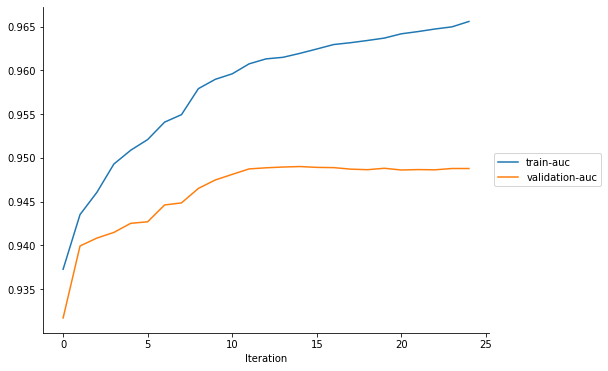

In [77]:
plot_collection(trial, "metrics")

In [79]:
def plot_feature_importance(trial, importance_type='weight'):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the suported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*"
    )

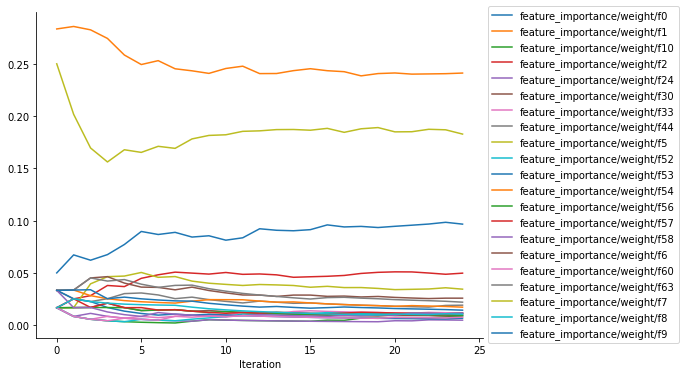

In [80]:
plot_feature_importance(trial)

# PART 3 - Deploying our model
Now let's deploy our model to an HTTPS endpoint, and enable data capture. All it takes is one line of code

In [81]:
from sagemaker.model_monitor.data_capture_config import DataCaptureConfig

from time import strftime, gmtime
timestamp = strftime("%d-%H-%M-%S", gmtime())

capture_path = 's3://{}/{}/capture/'.format(bucket, prefix)

xgb_endpoint = xgb.deploy(
    endpoint_name = "DEMO-xgboost-dm-{}".format(timestamp),
    
    
    initial_instance_count = 1,
    instance_type = "ml.m4.xlarge",
    
    data_capture_config = DataCaptureConfig(
        enable_capture = True,
        sampling_percentage = 100,
        #capture_options = ["REQUEST", "RESPONSE"],
        destination_s3_uri = capture_path
    )
)

---------------!

## Predicting with our model
First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as Numpy arrays in memory of our notebook instance. To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

Let's predict the first 10 samples from the test set.

In [85]:
sm = boto3.Session().client(service_name="runtime.sagemaker")

test_samples = [line.rstrip("\n") for line in open("test.csv")]
test_samples = test_samples[:10]

for sample in test_samples:
    sample = bytes(sample, "utf-8")
    response = sm.invoke_endpoint(EndpointName=xgb_endpoint.endpoint,
                                  ContentType='text/csv',
                                  Body=sample)
    print(response["Body"].read().decode('utf-8'))

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for d

0.03546415641903877
0.20384491980075836
0.007001238875091076
0.007001238875091076
0.0057500447146594524
0.01057447399944067
0.005609775427728891


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


0.0057500447146594524
0.23277632892131805
0.005609775427728891


For each sample, our binary classifier returns a probability between 0 and 1. Since we decided to maximize accuracy, the model sets a threshold of 0.5: anything lower is treated as a 0, anything higher as a 1.

To dive a little deeper: the threshold is baked in the metric that XGBoost uses. Here, we use the default 'eval_metric' for classification. i.e. 'error'. This metric has a default threshold of 0.5. If you look at the XGBoost doc (https://xgboost.readthedocs.io/en/latest/parameter.html), you'll see that it's possible to pass a different threshold, doing something like: xgb.set_hyperparameters(objective='binary:logistic', num_round=100, eval_metric='error@0.2')

In [86]:
%%sh -s "$capture_path"
echo $1
sleep 120
aws s3 ls --recursive $1
aws s3 cp --recursive $1 .

s3://williamli-ml-sagemaker/sagemaker/DEMO-xgboost-dm/capture/
2022-04-10 05:37:57      10312 sagemaker/DEMO-xgboost-dm/capture/DEMO-xgboost-dm-10-05-26-13/AllTraffic/2022/04/10/05/36-16-906-a2d61cd1-0e26-4760-9ac2-01664f30df77.jsonl
download: s3://williamli-ml-sagemaker/sagemaker/DEMO-xgboost-dm/capture/DEMO-xgboost-dm-10-05-26-13/AllTraffic/2022/04/10/05/36-16-906-a2d61cd1-0e26-4760-9ac2-01664f30df77.jsonl to DEMO-xgboost-dm-10-05-26-13/AllTraffic/2022/04/10/05/36-16-906-a2d61cd1-0e26-4760-9ac2-01664f30df77.jsonl


In [87]:
%%sh
head DEMO-xgboost-dm-10-05-26-13/AllTraffic/2022/04/10/05/36-16-906-a2d61cd1-0e26-4760-9ac2-01664f30df77.jsonl

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"32,440,1,0,1.4,94.465,-41.8,4.962,5228.1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.03546415641903877","encoding":"CSV"}},"eventMetadata":{"eventId":"b2e8b06d-d586-4a02-9ba3-3ac7bfade811","inferenceTime":"2022-04-10T05:36:16Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"33,422,5,0,1.4,93.444,-36.1,4.965,5228.1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.20384491980075836","encoding":"CSV"}},"eventMetadata":{"eventId":"1eb47d33-be4b-44e5-903d-2f014b319565","inferenceTime":"2022-04-10T05

## Use batch prediction
Some use cases either don't require or don't work well with HTTPS-based prediction. Imagine having to predict 100GB of bulk data every 24 hours: it wouldn't be efficient to do this with an endpoint.

SageMaker support batch prediction. Let's apply it to the model we trained earlier: run the next 2 cells and wait for a bit. While this takes place, head out to the SageMaker web console and familiarize yourself with the "Batch transform jobs" section.

In [88]:
transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge')

# Reminder: test.csv much only contain features, not the target value
transformer.transform("s3://{}/{}/test/test.csv".format(bucket, prefix), content_type='text/csv')

...................................[2022-04-10:05:55:55:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-10:05:55:55:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-10:05:55:55:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-04-10 05:55:55 +0000] [18] [INFO] Starting 

In [89]:
transformer.wait()
print(transformer.output_path)

[2022-04-10:05:55:55:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-10:05:55:55:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-10:05:55:55:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
[2022-04-10:05:55:55:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-10:

## Copy the output file and display the first 10 predictions
Predictions are written to S3. Let's use the AWS CLI to retireve them and display the first 10 probabilities.

In [92]:
!aws s3 cp $transformer.output_path/test.csv.out .
!ls -l test.csv.out
!head -10 test.csv.out

download: s3://sagemaker-us-east-1-432449956699/sagemaker-xgboost-2022-04-10-05-50-16-884/test.csv.out to ./test.csv.out
-rw-r--r-- 1 root root 84125 Apr 10 05:56 test.csv.out
0.03546415641903877
0.20384491980075836
0.007001238875091076
0.007001238875091076
0.0057500447146594524
0.01057447399944067
0.005609775427728891
0.0057500447146594524
0.23277632892131805
0.005609775427728891


## Deleting the endpoint
Once that we're done predicting, we can delete the endpoint (and stop paying for it). You can re-deploy again by runnig the appropriate cell above.

In [93]:
sagemaker.Session().delete_endpoint(xgb_endpoint.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
